# 2. 랭킹 올려보기

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_forat = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, "train.csv")
test_data_path = join(data_dir, "test.csv")

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#### train 컬럼 정리

In [64]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [65]:
# 정수형으로 처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [66]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [67]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### test에서도 똑같이

In [68]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [69]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

#### 가격 데이터의 분포 확인해보기

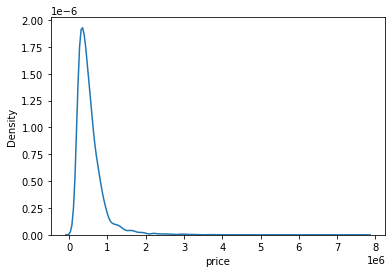

In [70]:
sns.kdeplot(y)
plt.show()

In [71]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

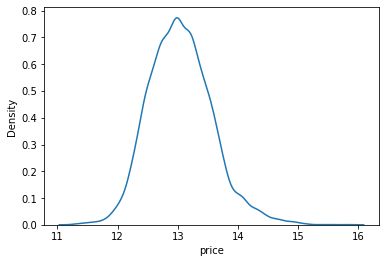

In [72]:
sns.kdeplot(y)
plt.show()

##### 모두 int, float형으로 모델 학습에 활용하기 문제 없을 것

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2-2. 함수로 만들어 쓰기
- 여러 가지 반복되는 작업들은 함수로 만들자 ****

#### RMSE 계산

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_test, y_pred는 위에서 np.log1p()로 변환된 값이므로 원래 데이터로 되돌리기 위해 np.expm1()을 추가해야 함

In [75]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 모델 가져오기

In [76]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

모델 인스턴스 생성한 후 models라는 리스트에 넣어주기

In [77]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
# random_state=None    # 이게 초기값. 아무것도 지정하지 않고 None 넘겨주면 모델 내부에서 임의로 선택 
random_state=2020     # 고정값 세팅하기

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

모델 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있음

In [78]:
gboost.__class__.__name__

'GradientBoostingRegressor'

#### 4가지 모델에 대해 RMSE 값 얻기

In [79]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # 내림차순 정렬
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

#### 위의 과정을 get_scores(models, train, y) 함수로 만들어보기

In [80]:
def get_scores(models, train, y):
    
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # 내림차순 정렬
    
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 2-3. 그리드 탐색
RMSE 결과값을 나타내주는 함수가 준비되어 있으니, 다양한 하이퍼파라미터로 실험을 해보자

In [81]:
from sklearn.model_selection import GridSearchCV

#### 🧤그리드 탐색
- 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 (격자와 같이) 탐색
- 사람이 정해둔 값들로 조합 탐색하므로 최적의 조합 놓칠 수 있음 <br/>

#### 🧤랜덤 탐색
- 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해 탐색하는 방법
- 랜덤으로 탐색하기 때문에 최적의 조합 찾을 수 있지만 가능성 또한 랜덤성에 의존 (보장 x)

#### ✔️GridSearchCV
- param_grid: 탐색할 파라미터 종류
- scoring: 모델의 성능을 평가할 지표
- cv: cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 수
- verbose: 그리드 탐색을 진행하며 진행 과정을 출력해서 보여줄 메시지 양
- n_jobs: 그리드 탐색 진행하며 사용할 CPU 수

#### 하이퍼 파라미터

In [82]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

#### 모델 (LightGBM)

In [83]:
model = LGBMRegressor(random_state=random_state)

#### 다양한 인자 넣어 GridSearchCV 수행하기
- param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험 완료

In [84]:
# grid_model 초기화
grid_model = GridSearchCV(model,
                         param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         verbose=1,
                         n_jobs=5)

# train과 y로 간단한 학습
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

##### 실험에 대한 결과는 grid_odel.cv_results_ 안에 저장됨

In [85]:
grid_model.cv_results_

{'mean_fit_time': array([0.18177342, 0.17733426, 0.3156971 , 0.47050962]),
 'std_fit_time': array([0.06609748, 0.00728564, 0.0163512 , 0.07503963]),
 'mean_score_time': array([0.00695162, 0.01601491, 0.02206554, 0.03191514]),
 'std_score_time': array([0.00026654, 0.0103864 , 0.01004504, 0.0102496 ]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [86]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [87]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [88]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


#### ✔️점수가 음수인 이유는?
위에서 score에 neg_mean_squared_error, 즉 MSE에 음수를 취한 값을 넣었기 때문이다.

In [89]:
results['RMSE'] = np.sqrt(-1 * results['score']) # 음수였기 때문에 마이너스 붙이기
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


✔️우리는 위에서 price에 log를 취해주어 다시 expm1를 이용해 원래대로 복원한 뒤 RMSE를 계산하였다. <br/>
✔️하지만 그리드 탐색을 하면서는 exmp1로 변환하는 과정이 없었기 때문에 log가 취해져있는 price데이터의 손실합수값을 계산하게 된 것 ! <br/>
✔️즉, 엄밀히 말하면 그리드 탐색의 RMSE는 RMSLE(Root Mean Squared Log Error)

In [90]:
# 컬럼 이름 RMSLE로 변환해주기
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [91]:
# RMSLE 낮은 순대로 (오름차순) 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [94]:
# 모든 과정 한 함수에 담기

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                         param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         verbose=verbose,
                         n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)
    
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [95]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


제일 좋은 조합은 max_depth=10, n_estimators=100이구나!

In [96]:
# 해당 파라미터로 구성된 모델 준비하고, 학습 후 예측 결과 생성하기

model = LGBMRegressor(max_depth=10,
                     n_estimators=100,
                     random_stat=random_state)
model.fit(train, y)

prediction = model.predict(test)
prediction

array([13.13498986, 13.06690353, 14.11202067, ..., 12.98496696,
       12.70900921, 12.95815607])

In [97]:
# 예측 결과에 np.expm1() 씌우기
prediction = np.expm1(prediction)
prediction

array([ 506352.26558681,  473024.00582453, 1345155.15609376, ...,
        435811.3151346 ,  330712.99128413,  424282.04332686])

submission 파일 가져와보기

In [98]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [99]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.063523e+05
1,15036,4.730240e+05
2,15037,1.345155e+06
3,15038,2.857408e+05
4,15039,3.263876e+05


In [100]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_

In [102]:
# 위 과정을 하나의 함수로 만들기

def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [103]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Unknown parameter: random_stat
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


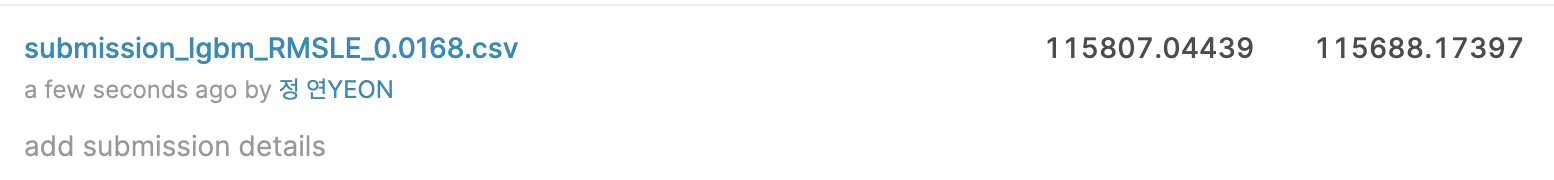